### 展示专家推荐的服装搭配组合

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

#### 一、读取搭配组合，存储至字典

##### （一）原始数据展示

In [42]:
# 原始数据展示
root = '../Dataes/OriginDataes/dim_fashion_matchsets.txt'
data = pd.read_csv(root,sep=' ')
data.columns = ['index','item_set'] # 定义列名
data = data.drop('index',axis=1) # 删除index列名
data.head(5)

,item_set
0,1842610;2741506
1,"893028;993019,1375599,1913565,3036503;2849440;..."
2,2612866;1272124;2181942
3,3128145;2683359;855149
4,642818;2636382


##### （二）定义DataReader类，实现对原始数据的处理

|类型|名称|输入|输出|说明|
|--|--|--|--|--|
|变量|root|||专家推荐搭配组合所在的文件路径|
|变量|matches|||以dataframe格式保存的搭配信息|
|方法|__init__(self)|无|无|初始化函数，实现文件的读入，搭配信息的生成|
|方法|create_sets(self)|无|summary(dict)：处理后的搭配信息数据|将生成的搭配信息，根据搭配信息的格式再次处理，以字典形式保存|
|方法|acount_num(self,sets)|sets|count(int)|统计每个搭配类别中的容量大小|

##### （三）DataReader对象的操作流程

* 初始化对象，对象实例化时调用__init__()实现:读取专家搭配数据'dim_fashion_matchsets.txt',转换成dataframe格式，赋值于self.matchsets
* 数据处理，对象调用create_sets()实现:读取self.matchsets,通过分隔符';',切分相互组合搭配的服装集合,以列表的形式保存;通过分隔符',',切分同一集合下的可替换服装搭配，以列表的形式保存;返回summary,为字典格式；其中key为搭配索引号，范围为0~len(summary-1);values为列表形式的各搭配组合;
* 数据统计，对象调用acount_num()实现:读取每个搭配组合数据（字符串），根据分隔符统计每个大类（每个搭配）的具体容量，并返回，结果为列表形式，count[i]表示第i个搭配的各类服装的数量情况

* DataReader类的实现

In [61]:
class DataReader:
    # 初始化函数,读取文件dim_fashion_matchsets.txt文件
    def __init__(self):
        self.root = '../Dataes/OriginDataes/dim_fashion_matchsets.txt'
        matchsets = pd.read_csv(self.root,sep=' ')
        matchsets.columns = ['index','item_set'] # 定义列名
        self.matchsets = matchsets.drop('index',axis=1) # 删除index列名
    
    # 处理文件,根据self.matchsets生成对应组合，存储在字典中
    def create_summary(self):
        summary = {} #存储总的搭配组合
        for i in range(0,len(self.matchsets[:20])):
            sets = self.matchsets['item_set'][i] # 原搭配信息
            big_cloths = sets.split(';') # 分割各大类
            count = self.acount_num(sets) #计算当前组合下各大类的数量
            # print(count)
            for j in range(0,len(count)):
                cloths = big_cloths[j].split(',')
                big_cloths[j] = cloths
            summary[i] = big_cloths
        return summary
    # 给定搭配组合（字符串），得到各大类的数量，以列表的形式返回
    def acount_num(self,sets):
        types = sets.split(';')
        count = []
        for type_cloths in types:
            num_cloth = type_cloths.split(',')
            count.append(len(num_cloth))
        return count  

* 获取处理后的搭配信息，赋值至sets（字典格式）

In [68]:
# 读取数据
data = DataReader()
# 数据处理
summary = data.create_summary()
# 获取第i个服装搭配组合，此处i为1
item_sets_1 = data.matchsets['item_set'].tolist()[1]
# 统计该服装搭配组合的各类服装数量情况
data.acount_num(item_sets_1)

[1, 4, 1, 1, 3, 3, 1]

* sumamry预览

In [69]:
for i in range(0,5):
    print(summary[i])

[['1842610'], ['2741506']]
[['893028'], ['993019', '1375599', '1913565', '3036503'], ['2849440'], ['2546147'], ['2329974', '2661094', '347849'], ['884801', '127779', '3122713'], ['2338561']]
[['2612866'], ['1272124'], ['2181942']]
[['3128145'], ['2683359'], ['855149']]
[['642818'], ['2636382']]


#### 二、根据搭配组合，生成图片并展示

##### （一）原始数据展示

In [46]:
contents = pd.read_csv('../Dataes/OriginDataes/dim_items.txt',sep=' ')
contents.columns = ['item_id','cat_id','None']
contents = contents.drop('None',axis = 1)
contents.head(10)

,item_id,cat_id
0,49,228
1,59,284
2,109,461
3,119,368
4,154,188
5,179,228
6,264,368
7,374,368
8,414,368
9,424,160


##### （二）定义PicReader类，实现对服装图像的处理

|类型|名称|输入|输出|备注|
|--|--|--|--|--|
|变量|contents|||所有服装及其对应的类别文件所在的文件路径|
|方法|__init__(self)|无|无|初始化函数，实现文件的读入|
|方法|read_cat(self)|无|contents(dataframe)：处理后的服装种类信息|将生成的搭配信息，drop掉一些列，并以字典形式保存|
|方法|complete_cat(self,sets,contents)|sets(dict),contents(dataframe)|sets_new|遍历sets，对每个item_id进行索引，在contents中查找对应的cat_id,并拼接|
|方法|present_pic(self,item_sets)|items_sets(list)|无|通过图片展示item_sets(当前服装搭配组合)的图像信息|
|方法|store_img(self,item_sets,name)|items_sets(list),name(str)|无|存储展示的item_sets(当前服装搭配组合)的图片搭配结果（.png）|

##### （三）PicReader对象的操作流程

* 初始化对象，对象实例化时调用__init__()实现:调用read_cat()实现，读取专家搭配数据'dim_items.txt',转换成dataframe格式，赋值于self.contents
* 数据处理，对象调用complete(sets,contents)实现:读取sets,contents;对sets中的item_id进行遍历，在contents中进行检索并获取对应的cat_id,将二者拼接，用于读取文件路径
* 搭配组合图像数据生成，对象调用present_pic(item_sets)实现:读取item_sets,获取该搭配组合对应的图像数据，并生成和展示搭配组合的图像
* 搭配组合图像数据保存，对象调用store_img(item_sets,name)实现:将生成的item_sets对应的搭配组合图像，存储在name对应的路径下

In [71]:
class PicReader:
    # 初始化函数，指定图片的读取路径
    def __init__(self):
        self.contents = self.read_cat('../Dataes/OriginDataes/dim_items.txt')
    
    # 定义函数实现查表，返回当前item_id的路径
    # 注意，应当使用OriginData/dim_items.txt实现对对应大类的cat_id的检索
    def read_cat(self,path):
        # path = '../Dataes/OriginDataes/dim_items.txt'
        contents = pd.read_csv(path,sep=' ')
        contents.columns = ['item_id','cat_id','None']
        contents = contents.drop('None',axis = 1)
        return contents
    
    # 定义函数实现对item_id对应的文件路径作索引
    def complete_cat(self,sets,contents):
        # 遍历sets中的元素，将编号更改为cat_id/item_id
        sets_new = {}
        for cat in sets.items():
            key = cat[0]
            item_id_sets = cat[1]

            sets_new[key] = []
            for i in range(0,len(item_id_sets)):
                sets_new[key].append([])
                for item_id in item_id_sets[i]:
                    # 在contents中索引item_id 对应的cat_id
                    try:
                        cat_id = str(contents[contents['item_id'] == int(item_id)]['cat_id'].values[0])
                    except:
                        cat_id='未知'
                        print('error')
                    item_id_new = cat_id+'/'+str(item_id)
                    sets_new[key][i].append(item_id_new)
        return sets_new
    
    # 根据存储的文件路径读取并展示,sets中存储的为路径信息
    def prensent_pic(self,item_sets):
        pass
    
    
    # 定义函数实现对搭配组合的存储(图片形式)，输入为item_sets：列表格式的搭配组合；name：要保存的图片名
    def store_img(item_sets,name):
        # item_sets = sets_new[1]
        # 获取画布的长度和宽度(图片个数)
        height = max([len(item_set) for item_set in item_sets])
        weight = len(item_sets)
        # print('weight:%d,height:%d' %(weight,height))
        for i,item_set in enumerate(item_sets):
            for j,item in enumerate(item_set):
                img_path = '/root/cai/pics_classfied/' + item + '.jpg'
                index = j*weight+i+1
                try:
                    img = cv2.imread(img_path)
                    # img = cv2.imread('test1.png', 0)
                    # print('读取成功',img.shape)
                except:
                    #print('error')
                    img = cv2.imread('test1.png')
                    #img = cv2.imread('test1.png', 0)
                    print('读取失败:%s' %img_path)
                # print(height,weight,index)

                img = img[:,:,[2,1,0]] # cv2读取的图片，在使用plt输出的时候需要进行颜色通道的转换
                plt.subplot(height,weight,index)
                plt.imshow(img)
                if index<=weight: # 在第一行的图片标题设置为大类名称
                    plt.title('cloth')
                plt.axis('off')
                plt.xticks()
                plt.yticks()
        plt.savefig(name)
                # print('height:%d,weight:%d,index:%d'%(height,weight,j*weight+i+1))

In [72]:
pic = PicReader()
contents = pic.read_cat('../Dataes/OriginDataes/dim_items.txt')
sets_new = pic.complete_cat(sets,contents)

In [73]:
sets_new

{0: [['137/1842610'], ['368/2741506']],
 1: [['111/893028'],
  ['284/993019', '284/1375599', '284/1913565', '284/3036503'],
  ['155/2849440'],
  ['519/2546147'],
  ['461/2329974', '461/2661094', '461/347849'],
  ['160/884801', '160/127779', '160/3122713'],
  ['311/2338561']],
 2: [['111/2612866'], ['368/1272124'], ['303/2181942']],
 3: [['52/3128145'], ['516/2683359'], ['262/855149']],
 4: [['260/642818'], ['618/2636382']],
 5: [['284/2382346'], ['42/870180'], ['228/2026556']],
 6: [['262/2363273'], ['160/3074908'], ['228/1909856'], ['48/494164']],
 7: [['449/225098'],
  ['368/3109261', '368/1079118'],
  ['188/1355697', '188/2528981']],
 8: [['137/2223124'], ['505/646355']],
 9: [['111/1463018', '111/230955'],
  ['284/1596334', '284/1704853'],
  ['368/2226122', '368/284814', '368/36278', '368/480281']],
 10: [['262/486682'], ['368/1742221']],
 11: [['311/310592'], ['228/3261938']],
 12: [['48/1500795'], ['33/2851265']],
 13: [['111/1245610', '111/1958374', '111/979730'],
  ['137/769815

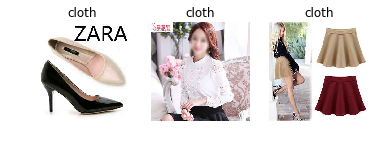

In [74]:
# 使用传统的列表处理方式
# for cat in sets_new.items():
#     key = cat[0]
#     item_sets = cat[1]
def print_img(item_sets,name):
    # item_sets = sets_new[1]
    # 获取画布的长度和宽度
    height = max([len(item_set) for item_set in item_sets])
    weight = len(item_sets)
    # print('weight:%d,height:%d' %(weight,height))
    for i,item_set in enumerate(item_sets):
        for j,item in enumerate(item_set):
            img_path = '/root/cai/pics_classfied/' + item + '.jpg'
            index = j*weight+i+1
            try:
                img = cv2.imread(img_path)
                # img = cv2.imread('test1.png', 0)
                # print('读取成功',img.shape)
            except:
                #print('error')
                img = cv2.imread('test1.png')
                #img = cv2.imread('test1.png', 0)
                print('读取失败:%s' %img_path)
            # print(height,weight,index)
            img = img[:,:,[2,1,0]]
            plt.subplot(height,weight,index)
            plt.imshow(img)
            if index<=weight:
                plt.title('cloth')
            plt.axis('off')
            plt.xticks()
            plt.yticks()
    plt.savefig(name)
            # print('height:%d,weight:%d,index:%d'%(height,weight,j*weight+i+1))
print_img(sets_new[5],'1')

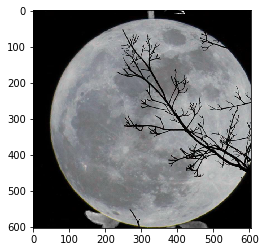

In [75]:
img = cv2.imread('test1.png')
plt.imshow(img)